# IK Pigeon System Training

In [1]:
from env.ik_pigeon_gym import IKPigeon
import numpy as np
import tensorflow as tf
import pickle
import os
from os import path

In [2]:
TOTAL_STEPS = 5000
TRAINING_STEPS = 4000
BATCH_SIZE = 64

## IK Pigeon Info
### Action Space
    Joint-number of dimensions
    Velocity control: (-np.inf, np.inf)
    Motor torque control: (-1.0, 1.0)
    
### Observation Space
    Position of the head relative to the body (2 dimensions)
    Angle of the head (1 dimension)
    for each joints (x number of joints dimensions; default of x is 3)
        Joint angle (1 dimension)
        Joint speed (1 dimension)
    Position of the body along the x-axis (1 dimension)
    Position of the head TARGET LOCATION relative to the body (2 dimensions)

In [3]:
env = IKPigeon()
X = np.empty((TOTAL_STEPS, 2)) # error vector between target and position of head end-effector
U = np.empty((TOTAL_STEPS, 3))
y = np.empty((TOTAL_STEPS, 2))

In [4]:
tf.random.set_seed(1)
np.random.seed(1)

## Sample Trajectories

In [5]:
# the state vector should be the error
obs = env.reset()
x_present = obs[-2:] - obs[:2]
for num_timestep in range(TOTAL_STEPS):
    u = env.action_space.sample()
    obs, _, done, _ = env.step(u)
    x_prime = obs[-2:] - obs[:2]
    
    X[num_timestep] = x_present
    U[num_timestep] = u
    # should be the velocity of the error instead of the next step
    y[num_timestep] = x_prime - x_present
    x_present = x_prime
    if done:
        x_present = env.reset()
env.close()

## Tensorflow Dataset

In [6]:
if not path.exists('./ik_pigeon_system_model'):
  os.mkdir('./ik_pigeon_system_model')

In [7]:
# create tensorflow dataset object instance; concat X and y
dataset_xu = tf.data.Dataset.from_tensor_slices((X, U))
dataset_y = tf.data.Dataset.from_tensor_slices(y)
dataset = tf.data.Dataset.zip((dataset_xu, dataset_y)).shuffle(500, reshuffle_each_iteration = False)
print(dataset)
# split trajectories into training and testing (no validation)
dataset_training = dataset.take(TRAINING_STEPS)
dataset_testing = dataset.skip(TRAINING_STEPS)
# split training data into batches
dataset_training = dataset_training.repeat(5).batch(BATCH_SIZE)
print(dataset_training)
print(dataset_testing)

<ShuffleDataset shapes: (((2,), (3,)), (2,)), types: ((tf.float64, tf.float64), tf.float64)>
<BatchDataset shapes: (((None, 2), (None, 3)), (None, 2)), types: ((tf.float64, tf.float64), tf.float64)>
<SkipDataset shapes: (((2,), (3,)), (2,)), types: ((tf.float64, tf.float64), tf.float64)>


2022-04-27 12:53:48.452640: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# ShuffleDataset inner workings
print(dataset)
print(dataset.as_numpy_iterator())
for x, i in dataset.as_numpy_iterator():
    print("X and U Sample")
    print(x[0])
    print(x[1])
    print("X Prime Sample")
    print(i)
    break

<ShuffleDataset shapes: (((2,), (3,)), (2,)), types: ((tf.float64, tf.float64), tf.float64)>
X and U Sample
[ 1.36454964 -0.23523521]
[1.09839833 0.31946599 0.83653164]
X Prime Sample
[-0.07782173 -0.11942863]


In [9]:
# BatchDataset / TakeDataset inner workings
print(dataset_training)
for x, i in dataset_training.as_numpy_iterator():
    print("Batch Size: ", len(x[0]))
    print("X and U Sample")
    print(x[0][0], x[1][0])
    print("X Prime Sample")
    print(i[0])
    break

<BatchDataset shapes: (((None, 2), (None, 3)), (None, 2)), types: ((tf.float64, tf.float64), tf.float64)>
Batch Size:  64
X and U Sample
[ 1.36454964 -0.23523521] [1.09839833 0.31946599 0.83653164]
X Prime Sample
[-0.07782173 -0.11942863]


In [10]:
# SkipDataset inner workings
print(dataset_testing)
for x, i in dataset_testing.as_numpy_iterator():
    print("Repetition: ", len(x[0]))
    print("X and U Sample")
    print(x[0], x[1])
    print("X Prime Sample")
    print(i)
    break

<SkipDataset shapes: (((2,), (3,)), (2,)), types: ((tf.float64, tf.float64), tf.float64)>
Repetition:  2
X and U Sample
[ 2.32188416 23.22608757] [ 0.06611658 -0.28167588 -0.93256336]
X Prime Sample
[ 0.05021858 -0.14773178]


## Model Definition and Training

In [11]:
class IKPigeonControlSystem(tf.keras.Model):
    def __init__(self):
        super(IKPigeonControlSystem, self).__init__()
        self.A = tf.keras.layers.Dense(2, input_shape = (2, ), 
                                       activation = 'linear', 
                                       use_bias = False, # Dense is meant to be used as NN layer
                                       name = 'A')
        
        self.B = tf.keras.layers.Dense(2, input_shape = (3, ), 
                                       activation = 'linear', 
                                       use_bias = False, 
                                       name = 'B')
        
        self.add = tf.keras.layers.Add()
        
    def call(self, inputs):
        x, u = inputs
        return self.A(x) + self.B(u)

Uses reference code in *Python Machine Learning: 3rd Edition* (Raschka and Mirjalili, 2019) pp. 438, 512-515

In [12]:
# compile model
model = IKPigeonControlSystem()
model.compile(tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics = [tf.keras.metrics.MeanSquaredError()])
history = model.fit(dataset_training, epochs = 200)
tf.keras.models.save_model(
    model, './ik_pigeon_system_model', overwrite = True, include_optimizer = True, save_format = None,
    signatures = None, options = None, save_traces = True
)

Epoch 1/200
313/313 [==============================] - 1s 1ms/step - loss: 272.0120 - mean_squared_error: 272.0120
Epoch 2/200
313/313 [==============================] - 0s 2ms/step - loss: 162.8068 - mean_squared_error: 162.8068
Epoch 3/200
313/313 [==============================] - 0s 1ms/step - loss: 92.5971 - mean_squared_error: 92.5971
Epoch 4/200
313/313 [==============================] - 0s 1ms/step - loss: 48.5874 - mean_squared_error: 48.5874
Epoch 5/200
313/313 [==============================] - 0s 1ms/step - loss: 23.1391 - mean_squared_error: 23.1391
Epoch 6/200
313/313 [==============================] - 1s 2ms/step - loss: 9.8856 - mean_squared_error: 9.8856
Epoch 7/200
313/313 [==============================] - 1s 2ms/step - loss: 3.8152 - mean_squared_error: 3.8152
Epoch 8/200
313/313 [==============================] - 0s 1ms/step - loss: 1.4084 - mean_squared_error: 1.4084
Epoch 9/200
313/313 [==============================] - 0s 1ms/step - loss: 0.5675 - mean_squared_e

313/313 [==============================] - 0s 2ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 75/200
313/313 [==============================] - 1s 2ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 76/200
313/313 [==============================] - 0s 2ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 77/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 78/200
313/313 [==============================] - 1s 2ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 79/200
313/313 [==============================] - 1s 2ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 80/200
313/313 [==============================] - 0s 1ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 81/200
313/313 [==============================] - 1s 2ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 82/200
313/313 [==============================] - 1s 2ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch

2022-04-27 12:55:29.656700: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/Users/johnlime/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [13]:
with open('./ik_pigeon_system_model/history.pkl', 'wb') as filepath:
    pickle.dump(history, filepath)

INFO:tensorflow:Assets written to: ram://0ee00e1a-7caf-4d68-8132-70ae16e88ec6/assets


/Users/johnlime/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Model Evaluation and Learning Curve Visualization

In [14]:
model = tf.keras.models.load_model(
    './ik_pigeon_system_model', custom_objects=None, compile=True, options=None
)

history = None
with open('./ik_pigeon_system_model/history.pkl', 'rb') as filepath:
    history = pickle.load(filepath)
    
history_keys = history.history.keys()

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def show_history(history_obj, y_data_name):
    # plt.plot(range(history_obj.params['epochs']), history_obj.history[y_data_name])
    plt.plot(range(100), history_obj.history[y_data_name][:100])
    plt.xlabel("Epochs")
    plt.ylabel(y_data_name)
    plt.savefig('./ik_pigeon_system_model/' + y_data_name + '.png')
    plt.show()

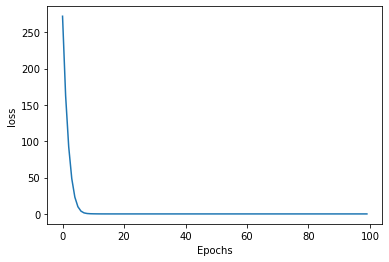

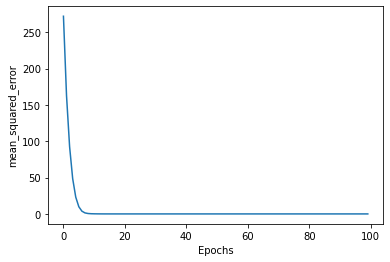

In [17]:
for i, key in enumerate(history.history.keys()):
  show_history(history, key)

In [18]:
model.summary()

Model: "ik_pigeon_control_system"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 A (Dense)                   multiple                  4         
                                                                 
 B (Dense)                   multiple                  6         
                                                                 
 add (Add)                   multiple                  0         
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [19]:
prediction_result = model.evaluate(dataset_testing.batch(8))
print(prediction_result)

125/125 [==============================] - 0s 901us/step - loss: 0.0115 - mean_squared_error: 0.0115
[0.011515256948769093, 0.011515256948769093]
